In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import mne
from nice.algorithms.connectivity import epochs_compute_wsmi
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold
mne.set_log_level('WARNING')
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


from scipy.ndimage import gaussian_filter1d

def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

sigma = 2

#have been preprocessing once i have picked out the trials. i should really just do this across all of the data, and then pick out the trials to use. 
#might only be able to do this within each dataset

def preprocess(data):
    data = zscore(data, axis = 0)
    data = detrend(data, axis = 0)
    return data
 

#this can run all of the pairs in ~ 
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)


agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_SP_attleft_agg = copy.deepcopy(agg_structure)
right_input_SP_attleft_agg = copy.deepcopy(agg_structure)
attention_SP_attleft_agg = copy.deepcopy(agg_structure)

left_input_SP_attright_agg = copy.deepcopy(agg_structure)
right_input_SP_attright_agg = copy.deepcopy(agg_structure)
attention_SP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file & extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()


    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]

    # Extract SP signals
    left_input_SP = data['SP'][0][0]
    right_input_SP = data['SP'][0][1]
    attention_SP = data['SP'][0][2]

    for class_left in classes_left:
         for class_right in classes_right: 
    
            left_indices = np.where((omitted ==0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]
            right_indices = np.where((omitted ==0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]

            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty
          
            if len(left_indices) >= 1:
                left_input_attendingleft_t = left_input_SP[left_indices, 100:350, :]
                right_input_attendingleft_t = right_input_SP[left_indices, 100:350, :]
                attention_layer_attendingleft_t = attention_SP[left_indices, 100:350, :]

                num_trials_left, num_samples, num_neurons_left = left_input_attendingleft_t.shape
                num_neurons_attention = 80

                left_in_attleft_sm = smooth_with_gaussian(left_input_attendingleft_t, sigma=sigma) 
                right_in_attleft_sm = smooth_with_gaussian(right_input_attendingleft_t, sigma=sigma) 
                attlay_attleft_sm = smooth_with_gaussian(attention_layer_attendingleft_t, sigma=sigma) 

                for j in range(0, num_trials_left):
                    for i in range(0, num_neurons_left):
                        count_left = np.count_nonzero(left_input_attendingleft_t[j, :, i] == 1)
                        if count_left > 0:
                            left_in_attleft_sm[j, :, i] /= count_left
                        count_right = np.count_nonzero(right_input_attendingleft_t[j, :, i] == 1)
                        if count_right > 0:
                            right_in_attleft_sm[j, :, i] /= count_right


                    for i in range(0, num_neurons_attention):
                        count_attention = np.count_nonzero(attention_layer_attendingleft_t[j, :, i] == 1)
                        if count_attention > 0:
                            attlay_attleft_sm[j, :, i] /= count_attention


                left_in_attleft_sum = np.sum(left_in_attleft_sm, axis=2)
                right_in_attleft_sum = np.sum(right_in_attleft_sm, axis=2)
                attlay_attleft_sum = np.sum(attlay_attleft_sm, axis=2)


                left_input_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_in_attleft_sum)
                right_input_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_in_attleft_sum)
                attention_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attlay_attleft_sum)


            if len(right_indices) >= 1:
                left_input_attendingright_t = left_input_SP[right_indices, 100:350, :]
                right_input_attendingright_t = right_input_SP[right_indices, 100:350, :]
                attention_layer_attendingright_t = attention_SP[right_indices, 100:350, :]

                left_in_attright_sm = smooth_with_gaussian(left_input_attendingright_t, sigma=sigma) 
                right_in_attright_sm = smooth_with_gaussian(right_input_attendingright_t, sigma=sigma)
                attlay_attright_sm = smooth_with_gaussian(attention_layer_attendingright_t, sigma=sigma)

                num_trials_right, num_samples, num_neurons_right = left_input_attendingright_t.shape
                num_neurons_attention = 80


                for j in range(0, num_trials_right):
                    for i in range(0, num_neurons_right):
                        count_left = np.count_nonzero(left_input_attendingright_t[j, :, i] == 1)
                        if count_left > 0:
                            left_in_attright_sm[j, :, i] /= count_left
                        count_right = np.count_nonzero(right_input_attendingright_t[j, :, i] == 1)
                        if count_right > 0:
                            right_in_attright_sm[j, :, i] /= count_right    

                    for i in range(0, num_neurons_attention):
                        count_attention = np.count_nonzero(attention_layer_attendingright_t[j, :, i] == 1)
                        if count_attention > 0:
                            attlay_attright_sm[j, :, i] /= count_attention


                left_in_attright_sum = np.sum(left_in_attright_sm, axis=2)
                right_in_attright_sum = np.sum(right_in_attright_sm, axis=2)
                attlay_attright_sum = np.sum(attlay_attright_sm, axis=2)


                left_input_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_in_attright_sum)   
                right_input_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_in_attright_sum)
                attention_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attlay_attright_sum)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}

for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


Dataset 1 loaded in 21.14 seconds
Dataset 1 processed in 10.90 seconds
Dataset 2 loaded in 25.43 seconds
Dataset 2 processed in 9.93 seconds
Dataset 4 loaded in 13.93 seconds
Dataset 4 processed in 7.05 seconds
Dataset 8 loaded in 16.74 seconds
Dataset 8 processed in 5.74 seconds
Dataset 14 loaded in 17.81 seconds
Dataset 14 processed in 8.20 seconds
Dataset 15 loaded in 12.56 seconds
Dataset 15 processed in 8.20 seconds
Dataset 20 loaded in 14.18 seconds
Dataset 20 processed in 6.95 seconds
Dataset 23 loaded in 13.87 seconds
Dataset 23 processed in 6.71 seconds


Total load time = 202.16 seconds
attention_input_SP_attleft_all 01 raw = [[0.93246222 1.07114051 1.23926261 ... 0.03479987 0.03340672 0.03331667]
 [0.67006069 0.68412672 0.70026099 ... 0.00745653 0.00563546 0.00485437]
 [0.20844499 0.20004466 0.18767246 ... 0.04938514 0.05324532 0.05422492]
 ...
 [0.33197951 0.39899314 0.49925771 ... 0.08700956 0.08519198 0.08377392]
 [0.42552068 0.3856285  0.33343655 ... 0.03412926 0.03590206 0.03704256]
 [0.62264913 0.577116   0.51082826 ... 0.01293505 0.01587189 0.01786951]]
checking 01:---------------------- [[0.93246222 1.07114051 1.23926261 ... 0.03479987 0.03340672 0.03331667]
 [0.67006069 0.68412672 0.70026099 ... 0.00745653 0.00563546 0.00485437]
 [0.20844499 0.20004466 0.18767246 ... 0.04938514 0.05324532 0.05422492]
 ...
 [0.33197951 0.39899314 0.49925771 ... 0.08700956 0.08519198 0.08377392]
 [0.42552068 0.3856285  0.33343655 ... 0.03412926 0.03590206 0.03704256]
 [0.62264913 0.577116   0.51082826 ... 0.01293505 0.01587189 0.01786951]]


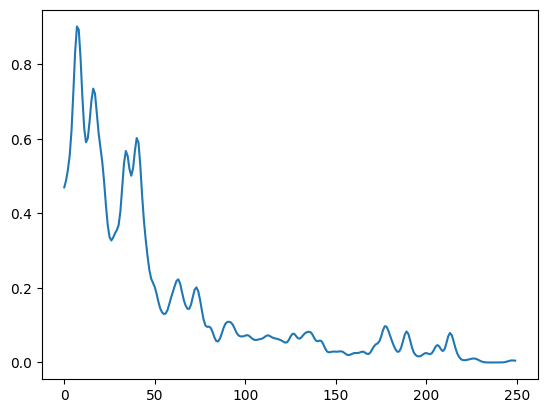

zscored [[ 1.83746824  2.19366148  2.42212746 ... -0.0570085  -0.10758496
  -0.10970262]
 [ 0.70020151  0.6694005   0.60265235 ... -1.05230571 -1.12594029
  -1.15943143]
 [-1.30047349 -1.2371656  -1.12766167 ...  0.47389493  0.61988463
   0.66142226]
 ...
 [-0.76506617 -0.45360333 -0.07586222 ...  1.84342325  1.79134911
   1.75123035]
 [-0.35965211 -0.50624022 -0.63561468 ... -0.08141855 -0.01608222
   0.02771328]
 [ 0.49471649  0.24793683 -0.03680424 ... -0.8528876  -0.75057647
  -0.67941517]]
att_attleft 01 = [[ 0.55070071  0.69106383  0.86087076 ...  0.06919172  0.0694834
   0.07107818]
 [ 0.35155264  0.36714885  0.3848133  ...  0.06690421  0.06661332
   0.06736242]
 [-0.0581397  -0.06552328 -0.07687873 ...  0.03393633  0.03881326
   0.0408096 ]
 ...
 [ 0.10648947  0.17418978  0.27514102 ...  0.03112626  0.02999534
   0.02926396]
 [ 0.17540967  0.13656256  0.08541567 ...  0.04215014  0.044968
   0.04715357]
 [ 0.35332893  0.30899516  0.24390677 ...  0.03985654  0.04399274
   0.04718

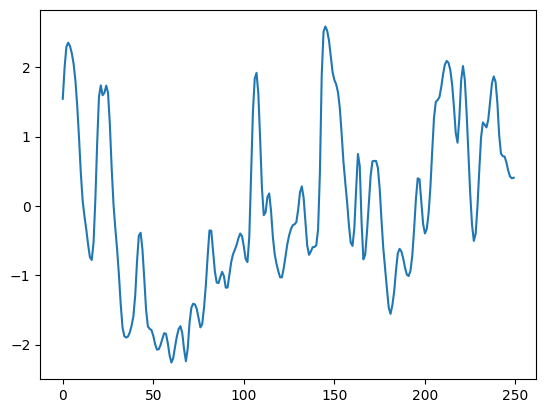

In [2]:
#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_input_SP_attleft_all = copy.deepcopy(all_structure)
right_input_SP_attleft_all = copy.deepcopy(all_structure)
attention_SP_attleft_all = copy.deepcopy(all_structure)

left_input_SP_attright_all = copy.deepcopy(all_structure)
right_input_SP_attright_all = copy.deepcopy(all_structure)
attention_SP_attright_all = copy.deepcopy(all_structure)

for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

#------ want to preprocess each array here now that they are properly compiled ----------------
#looking first at the shape / structure of left_input_SP_attleft_all:

for class_left in classes_left:
        for class_right in classes_right:
            left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

print('attention_input_SP_attleft_all 01 raw =', attention_SP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])

print('checking 01:----------------------', attention_SP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])
plt.plot(attention_SP_attleft_all[f'left_class_{1}'][f'right_class_{1}'][0])
plt.show()

print('zscored', zscore(attention_SP_attleft_all[f'left_class_{0}'][f'right_class_{1}'], axis = 0))

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)

for class_left in classes_left:
    for class_right in classes_right:
        left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

        left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])


def preprocess_data(data):
    # data = detrend(data, axis = 0)   #data seems to look nicer if i do this
    for i in range(len(data)):
        data[i] = detrend(data[i])

    if len (data) > 2:
        data = zscore(data, axis = 0)
    return data


left_attleft_pre = copy.deepcopy(all_structure)
right_attleft_pre = copy.deepcopy(all_structure)
att_attleft_pre = copy.deepcopy(all_structure)

left_attright_pre = copy.deepcopy(all_structure)
right_attright_pre = copy.deepcopy(all_structure)
att_attright_pre = copy.deepcopy(all_structure)

for class_left in classes_left:
    for class_right in classes_right:
        left_attleft_pre[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attleft_pre[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attleft_pre[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

        left_attright_pre[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attright_pre[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attright_pre[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

print('att_attleft 01 =', att_attleft[f'left_class_{0}'][f'right_class_{1}'])
plt.plot(att_attleft_pre[f'left_class_{0}'][f'right_class_{1}'][0])
plt.show()

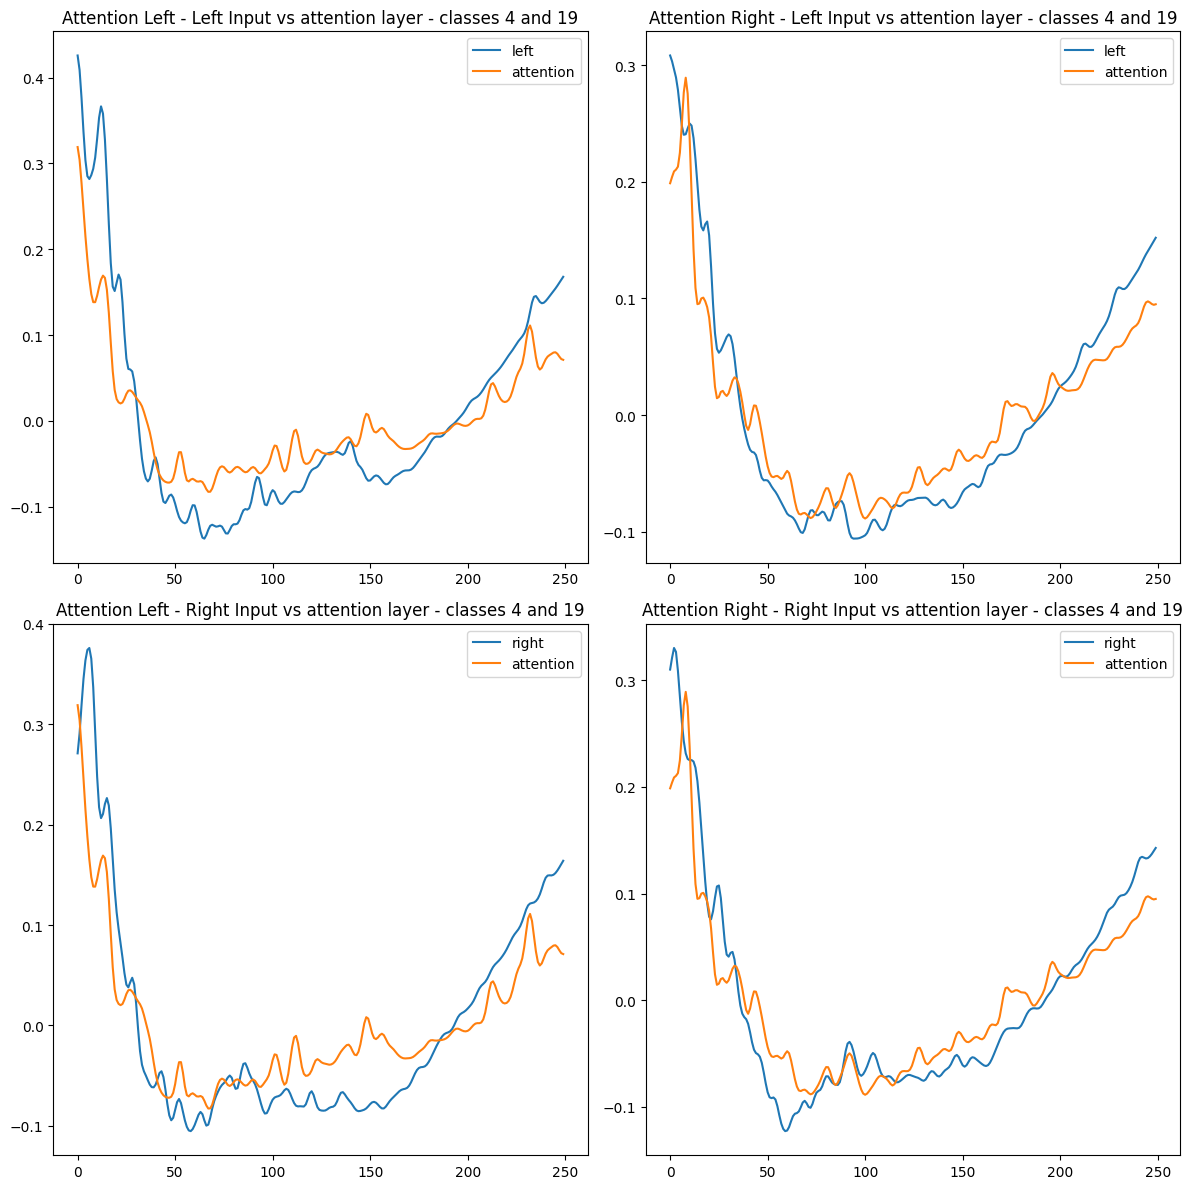

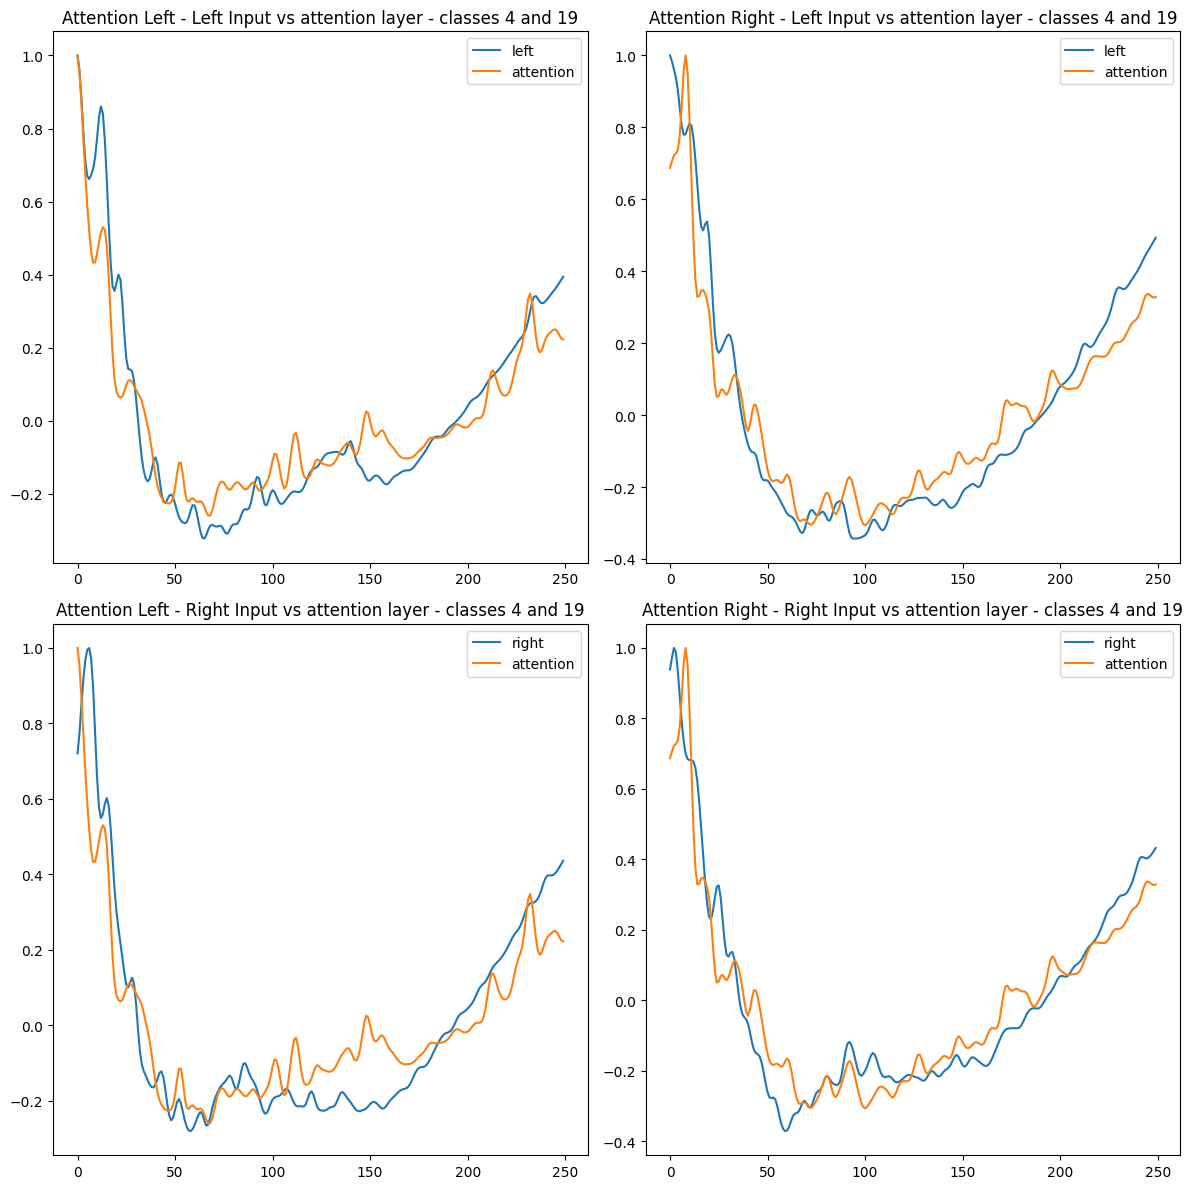

In [3]:
#---------------not processed-------------------
mean_left_attleft = copy.deepcopy(all_structure)
mean_right_attleft = copy.deepcopy(all_structure)
mean_attention_attleft = copy.deepcopy(all_structure)

mean_left_attright = copy.deepcopy(all_structure)
mean_right_attright = copy.deepcopy(all_structure)
mean_attention_attright = copy.deepcopy(all_structure)


#here take mean across all trials for each class pair
for class_left in classes_left:
    for class_righti in classes_right:
        mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = np.mean(left_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)
        mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)
        mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)

        mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)


##will select a class pair and plot the traces 
left, right = 4, 19
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title(f'Attention Left - Left Input vs attention layer - classes {left} and {right}')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title(f'Attention Left - Right Input vs attention layer - classes {left} and {right}')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title(f'Attention Right - Left Input vs attention layer - classes {left} and {right}')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title(f'Attention Right - Right Input vs attention layer - classes {left} and {right}')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

#-------------not processes, normalised
def norm(data):
    return data / np.max(data)

mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])

mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title(f'Attention Left - Left Input vs attention layer - classes {left} and {right}')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title(f'Attention Left - Right Input vs attention layer - classes {left} and {right}')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title(f'Attention Right - Left Input vs attention layer - classes {left} and {right}')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title(f'Attention Right - Right Input vs attention layer - classes {left} and {right}')
ax[1, 1].legend()

plt.tight_layout()
plt.show()





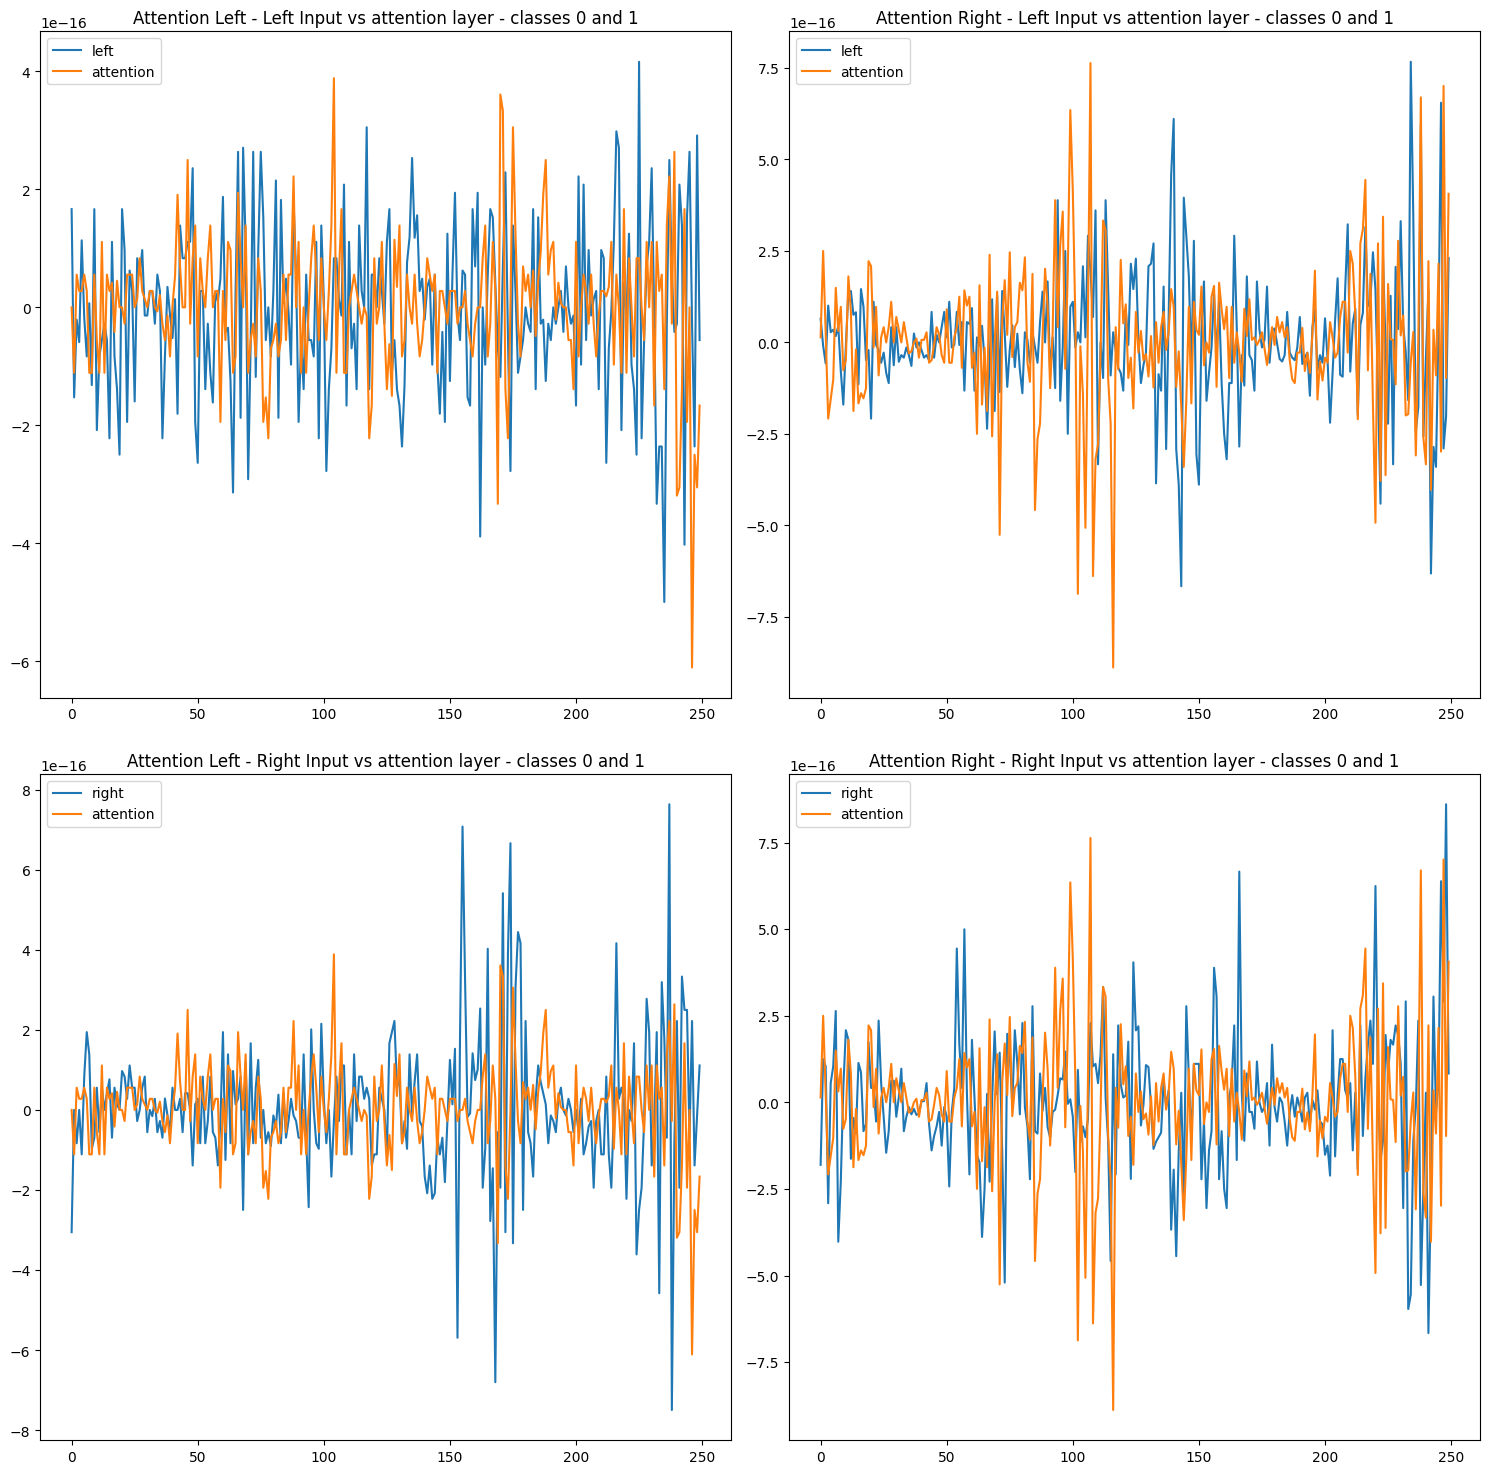

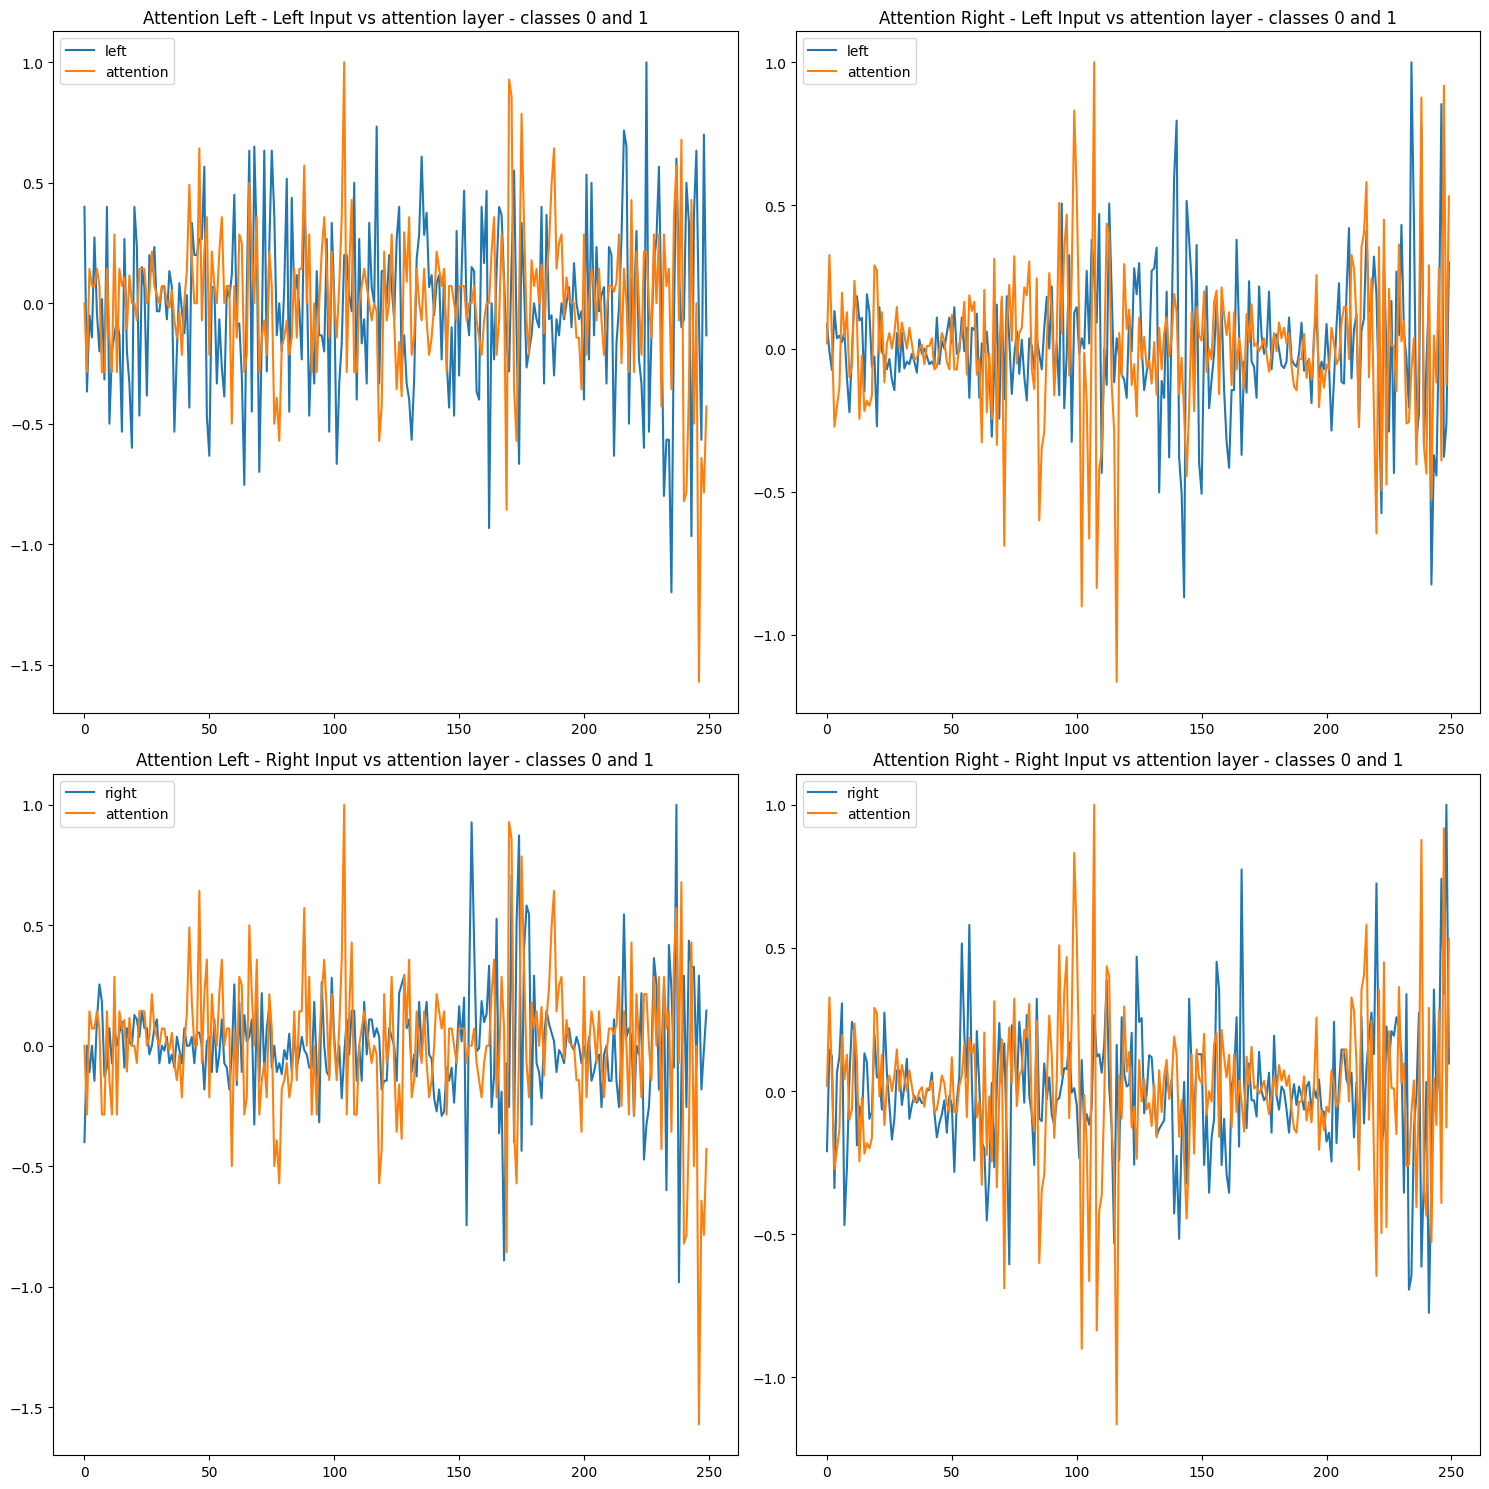

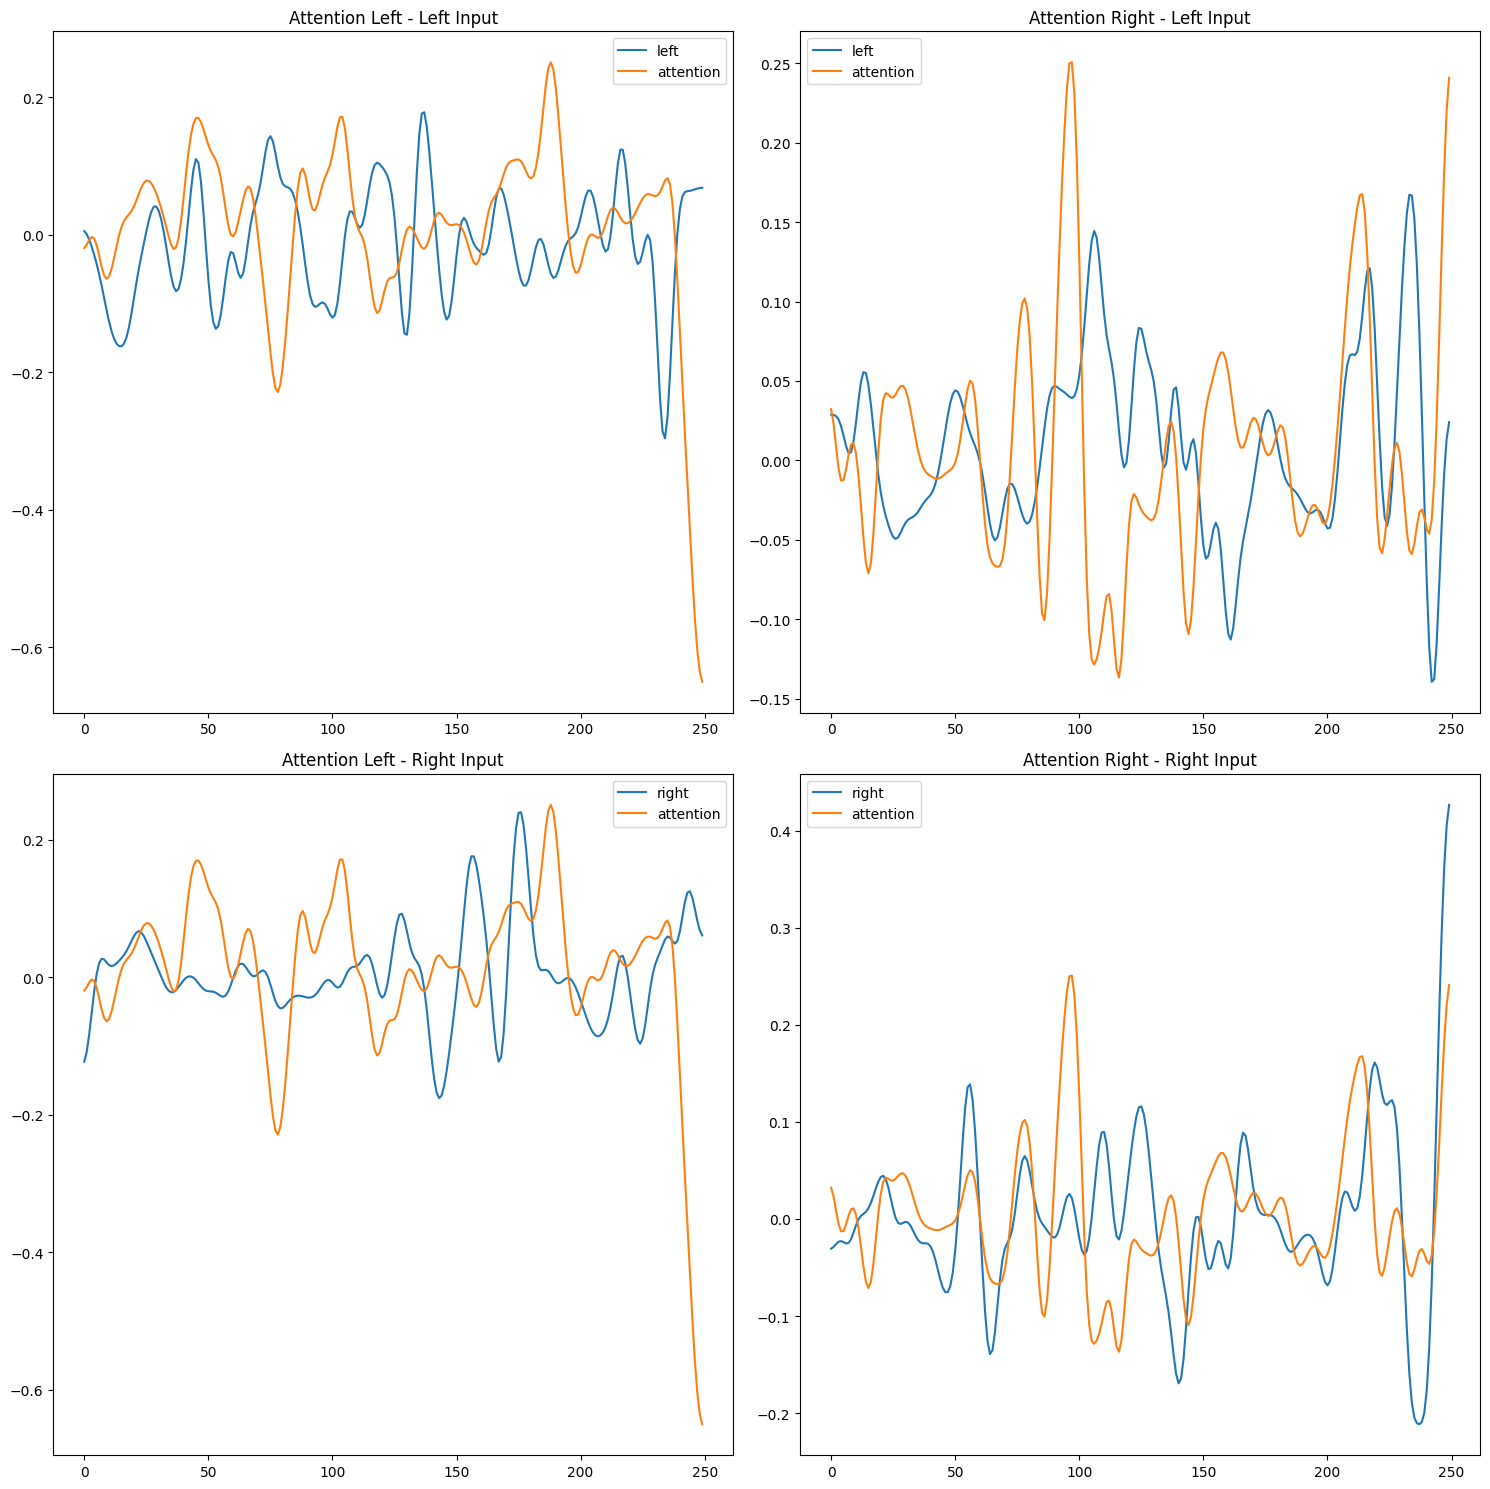

In [ ]:
#---------------not processed-------------------
mean_left_attleft = copy.deepcopy(all_structure)
mean_right_attleft = copy.deepcopy(all_structure)
mean_attention_attleft = copy.deepcopy(all_structure)

mean_left_attright = copy.deepcopy(all_structure)
mean_right_attright = copy.deepcopy(all_structure)
mean_attention_attright = copy.deepcopy(all_structure)


#here take mean across all trials for each class pair
for class_left in classes_left:
    for class_righti in classes_right:
        mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = np.mean(left_attleft_pre[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)
        mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attleft_pre[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)
        mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attleft_pre[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)

        mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(left_attright_pre[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attright_pre[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attright_pre[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)


##will select a class pair and plot the traces 
left, right = 0, 1
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title(f'Attention Left - Left Input vs attention layer - classes {left} and {right}')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title(f'Attention Left - Right Input vs attention layer - classes {left} and {right}')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title(f'Attention Right - Left Input vs attention layer - classes {left} and {right}')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title(f'Attention Right - Right Input vs attention layer - classes {left} and {right}')
ax[1, 1].legend()

plt.tight_layout()
plt.show()


#-------------not processes, normalised
def norm(data):
    return data / np.max(data)

mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])

mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title(f'Attention Left - Left Input vs attention layer - classes {left} and {right}')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title(f'Attention Left - Right Input vs attention layer - classes {left} and {right}')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title(f'Attention Right - Left Input vs attention layer - classes {left} and {right}')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title(f'Attention Right - Right Input vs attention layer - classes {left} and {right}')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

#----------not processed and smoothed---------------
from scipy.ndimage import gaussian_filter1d
def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma) 

mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] )

mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title('Attention Left - Left Input')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title('Attention Left - Right Input')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title('Attention Right - Left Input')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title('Attention Right - Right Input')
ax[1, 1].legend()

plt.tight_layout()
plt.show()



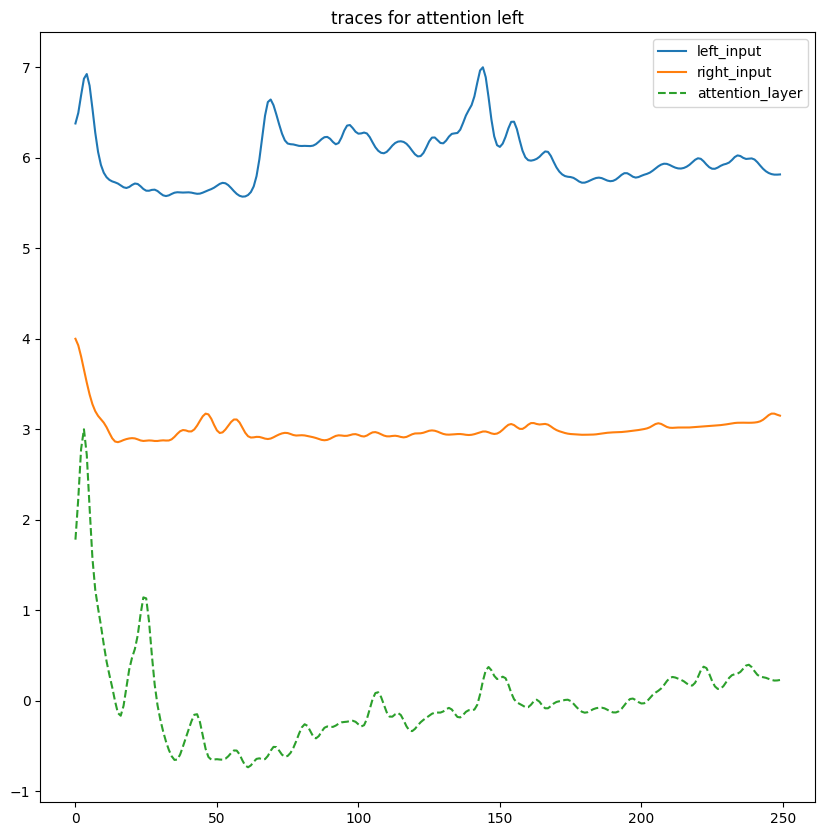

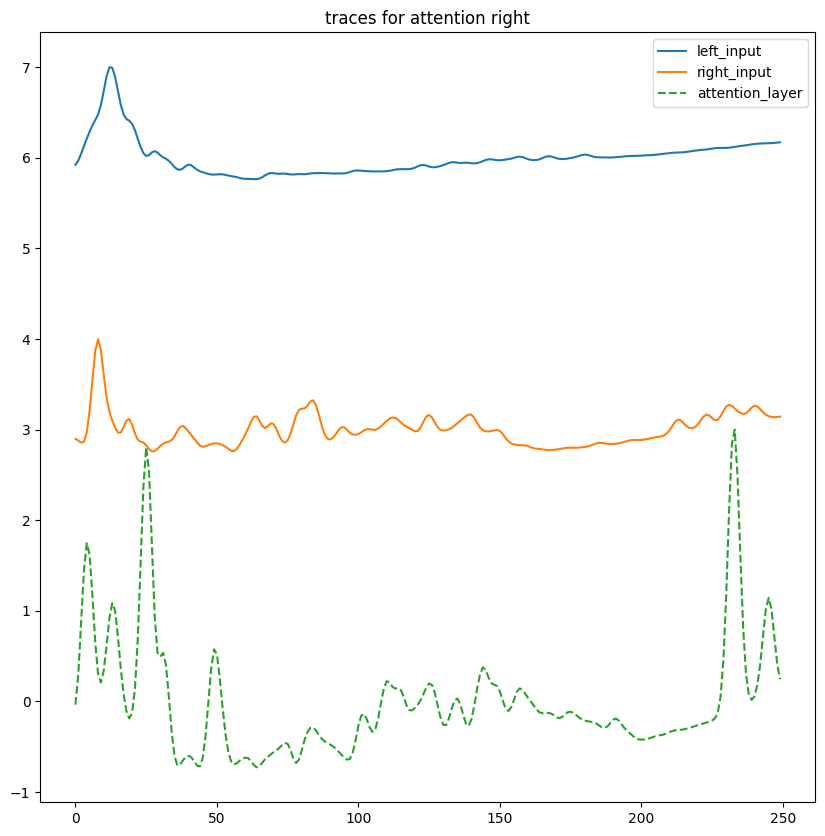

In [17]:
#-------------wsmi calculation----------------
n_times = 250
dt = 0.002
sfreq = 1 / dt

ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

lr_split_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right: 
     
        #reshaping data for attention left
        raw_data_left = np.concatenate([
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], 
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] ,
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] 
            ], axis=0)

        #print("raw_data_left shape =", raw_data_left.shape)  
        #Reshape into (n_channels, n_samples)
        raw_data_left = raw_data_left.reshape(3, -1)  
        #print('raw data left reshaped =', raw_data_left.shape) 
        raw_left = mne.io.RawArray(raw_data_left, info)
        #print("raw_data_left =", raw_left)


        events_left = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft']) ])
        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.498, baseline=None, preload=True)

        # if class_left == 0 and class_right == 1:
        #     print('raw_data_left =', raw_data_left)
        #     print('raw_data_left reshaped =', raw_data_left.shape)
        #     print('raw_left =', raw_left)
        #     #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        #     epochs_left.plot(n_epochs = 2, n_channels=3, scalings = 'auto', title="Attention Left")
        #     plt.show()

        if class_left == left and class_right == right:
            plt.figure(figsize=(10, 10))
            NL = np.max(raw_data_left[0][0:250])
            NR = np.max(raw_data_left[1][0:250])
            NA = np.max(raw_data_left[2][0:250])
            plt.plot((raw_data_left[0][0:250] / NL)+6, label='left_input')
            plt.plot((raw_data_left[1][0:250] / NR)+3, label='right_input')
            plt.plot(3 *raw_data_left[2][0:250] / NA, label='attention_layer', linestyle='--')
            plt.title('traces for attention left')
            plt.legend()
            plt.show()


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right:

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  #right class pairs that have trials
            print('no trials for this class pair')
            continue        

        #reshaping date for attention right 
        raw_data_right = np.concatenate([
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] 
        ], axis=0)

        #print('raw_data_right shape =', raw_data_right.shape)
        raw_data_right = raw_data_right.reshape(3, -1)
        #print('raw_data_right reshaped =', raw_data_right.shape)
        raw_right = mne.io.RawArray(raw_data_right, info)
        #print('raw_data_right =', raw_right)


        events_right = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright']) ]) 
        epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.498, baseline=None, preload=True)

        if class_left == left and class_right == right:
            plt.figure(figsize=(10, 10))
            NL = np.max(raw_data_left[0][0:250])
            NR = np.max(raw_data_left[1][0:250])
            NA = np.max(raw_data_left[2][0:250])
            plt.plot((raw_data_left[0][0:250] / NL)+6, label='left_input')
            plt.plot((raw_data_left[1][0:250] / NR)+3, label='right_input')
            plt.plot(3 * raw_data_left[2][0:250] / NA, label='attention_layer', linestyle='--')
            plt.title('traces for attention right')
            plt.legend()
            plt.show()